In [1]:
generating_class = 'YACHT'
real_dir = 'DATASET54000'
fake_dir = 'DCGAN-F64'
fake_dirx4 = 'DCGAN-F64x4'

In [2]:
from keras import layers
from keras import ops
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import os
import keras
import tensorflow as tf

import torch
import torchvision
import cv2

from realesrgan import RealESRGANer
from basicsr.archs.rrdbnet_arch import RRDBNet
from PIL import Image
import numpy as np
import requests

from skimage.metrics import structural_similarity as ssim
from torchvision import transforms
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.fid import FrechetInceptionDistance
from itertools import product


print(f"Versão do Tensorflow: {tf.__version__}")
devices = tf.config.list_physical_devices('GPU')
if devices:
    print(f"GPU disponivel: {devices}")
    print(f"Número de GPUs: {len(devices)}")
else:
    print("GPU não está disponível. Usando CPU")

print(f"PyTorch version: {torch.__version__}")
print(torchvision.__version__)
print(torch.cuda.is_available())  # Deve retornar True se a GPU estiver configurada corretamente
print(torch.cuda.get_device_name(0))  # Nome da GPU

2025-04-17 03:24:41.702906: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-17 03:24:41.723260: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Versão do Tensorflow: 2.16.1
GPU disponivel: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Número de GPUs: 1
PyTorch version: 2.0.1+cu118
0.15.2+cu118
True
NVIDIA GeForce RTX 4090


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
2025-04-17 03:24:43.487139: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-17 03:24:43.490119: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-17 03:24:43.490135: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/

Found 5400 files.


2025-04-17 03:24:50.693929: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-17 03:24:50.693966: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-17 03:24:50.693976: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-17 03:24:50.809545: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-17 03:24:50.809570: I external/local_xla/xla/stream_executor

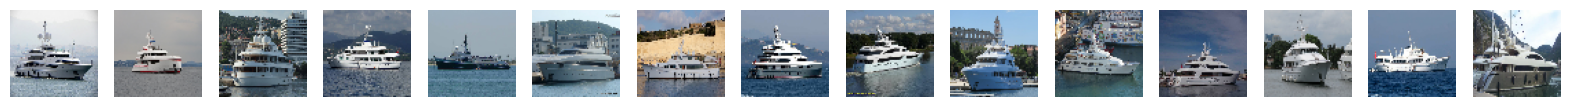

In [3]:
input_dir = str(real_dir + '/' + generating_class)

dataset = keras.utils.image_dataset_from_directory(
    input_dir, label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

for x in dataset:
    plt.figure(figsize=(20,15))

    for i in range (15):
        plt.subplot(1, 15, i + 1)
        plt.axis("off")
        plt.imshow((x.numpy() * 255).astype("int32")[i])
    break

In [4]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,801 (1.54 MB)

 Trainable params: 404,801 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 256)    │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 512)    │     2,097,664 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 3)      │        38,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,979,651 (15.18 MB)

 Trainable params: 3,979,651 (15.18 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, d_steps):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = d_steps
        self.seed_generator = keras.random.SeedGenerator(1337)
        

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = ops.shape(real_images)[0]
        total_d_loss = 0.0

        for _ in range(self.d_steps):
            random_latent_vectors = keras.random.normal(
                shape=(batch_size, self.latent_dim), seed=self.seed_generator
            )
    
            # Decode them to fake images
            generated_images = self.generator(random_latent_vectors)
    
            # Combine them with real images
            combined_images = ops.concatenate([generated_images, real_images], axis=0)
    
            # Assemble labels discriminating real from fake images
            labels = ops.concatenate(
                [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
            )
            # Add random noise to the labels - important trick!
            labels += 0.05 * tf.random.uniform(tf.shape(labels))
    
            # Train the discriminator
            with tf.GradientTape() as tape:
                predictions = self.discriminator(combined_images)
                d_loss = self.loss_fn(labels, predictions)
            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )
            total_d_loss += d_loss

        avg_d_loss = total_d_loss/self.d_steps
        
        # Update metrics
        self.d_loss_metric.update_state(avg_d_loss)

        # Sample random points in the latent space
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Assemble labels that say "all real images"
        misleading_labels = ops.zeros((batch_size, 1))
        
        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.g_loss_metric.update_state(g_loss)
            
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [7]:
# Diretório onde os modelos serão salvos
checkpoint_dir = str("DCGAN-MODELS/" + generating_class)
os.makedirs(checkpoint_dir, exist_ok=True)

# Caminho do modelo salvo
checkpoint_path = os.path.join(checkpoint_dir, "dcgan_checkpoint.keras")
best_path = os.path.join(checkpoint_dir, "best_dcgan_checkpoint.keras")

# Verifica se há um modelo salvo para continuar o treinamento
if os.path.exists(checkpoint_path):
    print("Carregando modelo salvo para continuar o treinamento...")
    generator = keras.models.load_model(checkpoint_path)
    discriminator = keras.models.load_model(checkpoint_path.replace("dcgan_checkpoint", "dcgan_discriminator"))
else:
    print("Nenhum modelo salvo encontrado. Treinando do zero...")

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=15, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(42)
        self.best_fid = 999

    def on_epoch_end(self, epoch, logs=None):      
        calc_dir = str('DCGAN-RESULTS' + "/" + generating_class)
        os.makedirs(calc_dir, exist_ok=True)
        calc_filename = str(generating_class + "%d.png")
        calc_path = os.path.join(calc_dir, calc_filename)

        random_latent_vectors = keras.random.normal(
            shape=(self.num_img, self.latent_dim), seed=self.seed_generator
        )
        generated_images = gan.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(calc_path % (i))

        real_class_dir = os.path.join(real_dir, generating_class)
        generated_class_dir = os.path.join('DCGAN-RESULTS', generating_class)
        
        real_files = [os.path.join(real_class_dir, f) for f in os.listdir(real_class_dir) if f.endswith(("png", "jpg", "jpeg"))]
        gen_files = [os.path.join(generated_class_dir, f) for f in os.listdir(generated_class_dir) if f.endswith(("png", "jpg", "jpeg"))]
        
        fid = FrechetInceptionDistance()
        
        for real_file, gen_file in zip(real_files, gen_files):
            real_batch = load_image(real_file)
            gen_batch = load_image(gen_file)
            fid.update(real_batch, real=True)
            fid.update(gen_batch, real=False)

        fid_score = fid.compute()
        print(f'   - FID: {fid_score.item()} .')

        save_fid[epoch] = fid_score.item()
        
        if fid_score.item() < self.best_fid:
            self.best_fid = fid_score.item()
            print(f"Melhor FID encontardo: {self.best_fid}, salvando gerador...")
            generator.save(best_path)
            discriminator.save(best_path.replace("best_dcgan_checkpoint", "best_dcgan_discriminator"))

        if (epoch + 1) % 100 == 0:
            plt.figure(figsize=(20, 15))
            for i in range (20):
                plt.subplot(1, 20, i + 1)
                plt.axis("off")
                amostra = keras.utils.array_to_img(generated_images[i])
                plt.imshow(amostra)
            plt.show()
            generator.save(checkpoint_path)
            discriminator.save(checkpoint_path.replace("dcgan_checkpoint", "dcgan_discriminator"))
            print(f"Modelo salvo após {epoch + 1} épocas.")

Nenhum modelo salvo encontrado. Treinando do zero...


In [8]:
### AUMENTO DE IMAGENS ###



weights_path = "RealESRGAN_x4plus.pth"

# Função para baixar os pesos se não existirem
def download_weights():
    if not os.path.exists(weights_path):
        print("Pesos do modelo não encontrados. Fazendo download...")
        url = "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth"
        response = requests.get(url, stream=True)
        with open(weights_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
        print("Download concluído!")

# Baixar os pesos, se necessário
download_weights()

def process_images(input_dir, output_dir):
    # Certifique-se de que o diretório de saída existe
    os.makedirs(output_dir, exist_ok=True)

    # Inicialize o modelo Real-ESRGAN
    model = RRDBNet(
        num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4
    )
    upscaler = RealESRGANer(
        scale=4,  # Fator de escala
        model_path=weights_path,  # Caminho dos pesos do modelo
        model=model,  # Modelo definido acima
        tile=0,  # Defina um tamanho de tile se tiver limitações de memória
        tile_pad=10,  # Padding ao redor dos tiles
        pre_pad=0,  # Preenchimento adicional antes do processamento
        half=True,  # Utilize FP16 para economizar memória em GPUs compatíveis
    )

    # Iterar sobre todas as imagens no diretório de entrada
    for filename in tqdm(os.listdir(input_dir),desc="Aumentando imagens"):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)

            try:
                # Abra a imagem de entrada
                with Image.open(input_path) as img:
                    # Converta a imagem para array NumPy
                    input_image = np.array(img)

                    # Aplique a super-resolução
                    sr_image, _ = upscaler.enhance(input_image, outscale=4)

                    # Salve a imagem processada
                    Image.fromarray(sr_image).save(output_path)
                    #print(f"Processado: {filename} -> {output_path}")
            except Exception as e:
                print(f"Erro ao processar {filename}: {e}")

In [18]:
### CÁLCULO DE MÉTRICAS ###



# Configurações globais
image_size = 64  # Dimensão para redimensionar imagens
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

# Função para carregar e pré-processar uma imagem
def load_image(image_path):
    with Image.open(image_path) as img:
        img = img.convert("RGB")
        tensor = transform(img) * 255  # Escalar de [0, 1] para [0, 255]
        return tensor.to(torch.uint8).unsqueeze(0)  # Adiciona dimensão de batch (1, C, H, W)

# Função para calcular SSIM
def calculate_ssim(img1, img2):
    img1 = np.array(img1)
    img2 = np.array(img2)
    return ssim(img1, img2, channel_axis=-1)

# Função principal para calcular métricas para uma classe específica
def calculate_metrics(real_dir, generated_dir, target_class, num_samples=100, batch_size=10):
    real_class_dir = os.path.join(real_dir, target_class)
    generated_class_dir = os.path.join(generated_dir, target_class)

    # Listar imagens nas pastas
    real_files = [os.path.join(real_class_dir, f) for f in os.listdir(real_class_dir) if f.endswith(("png", "jpg", "jpeg"))]
    gen_files = [os.path.join(generated_class_dir, f) for f in os.listdir(generated_class_dir) if f.endswith(("png", "jpg", "jpeg"))]

    if len(real_files) < num_samples or len(gen_files) < num_samples:
        raise ValueError(f"Imagens insuficientes para a classe '{target_class}'. É necessário pelo menos {num_samples} imagens por classe.")

    sampled_real = np.random.choice(real_files, num_samples, replace=False)
    sampled_gen = np.random.choice(gen_files, num_samples, replace=False)

    ssim_scores = []
    fid = FrechetInceptionDistance()
    inception_score_real = InceptionScore()
    inception_score_gen = InceptionScore()

    # Usar tqdm para mostrar o progresso
    for i in tqdm(range(0, num_samples, batch_size), desc=f"Processando classe '{target_class}'"):
        batch_real_files = sampled_real[i:i + batch_size]
        batch_gen_files = sampled_gen[i:i + batch_size]

        real_batch = []
        gen_batch = []

        for real_file, gen_file in zip(batch_real_files, batch_gen_files):
            with Image.open(real_file) as real_img, Image.open(gen_file) as gen_img:
                real_img = real_img.convert("RGB").resize((image_size, image_size))
                gen_img = gen_img.convert("RGB").resize((image_size, image_size))

                # Calcular SSIM
                ssim_scores.append(calculate_ssim(real_img, gen_img))

                # Preparar imagens para FID e Inception
                real_batch.append(load_image(real_file))
                gen_batch.append(load_image(gen_file))

        # Concatenar batches
        real_batch = torch.cat(real_batch, dim=0)
        gen_batch = torch.cat(gen_batch, dim=0)

        # Atualizar Inception Score e FID por batch
        inception_score_real.update(real_batch)
        inception_score_gen.update(gen_batch)
        fid.update(real_batch, real=True)
        fid.update(gen_batch, real=False)

    # Calcular métricas finais
    is_real, _ = inception_score_real.compute()
    is_gen, _ = inception_score_gen.compute()
    fid_score = fid.compute()

    # Salvar métricas
    metrics = {
        "SSIM (média)": np.mean(ssim_scores),
        "Inception Score (Real)": is_real.item(),
        "Inception Score (Gerado)": is_gen.item(),
        "FID": fid_score.item()
    }

    return metrics

# Função para exibir as métricas
def print_metrics(metrics, target_class):
    print(f"\nMétricas para a classe '{target_class}':")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

# Função para plotar resumo das métricas para a classe
def plot_metrics_for_class(metrics, target_class):
    labels = ["SSIM (média)", "FID", "Inception Score (Real)", "Inception Score (Gerado)"]
    values = [metrics["SSIM (média)"], metrics["FID"], metrics["Inception Score (Real)"], metrics["Inception Score (Gerado)"]]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(labels, values, color=['blue', 'orange', 'green', 'red'])
    plt.title(f"Métricas para a classe '{target_class}'")
    plt.ylabel("Valores")
    plt.tight_layout()

    # Adicionar os valores nas barras
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.2f}", ha='center', va='bottom')

    # Salvar o gráfico
    plt.savefig(f"DCGAN-RESULTS/DCGAN-METRICS-{target_class}.png")
    plt.show()

Epoch 1/2000


I0000 00:00:1744860302.040921    3490 service.cc:145] XLA service 0x1354c670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744860302.040951    3490 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-04-17 03:25:02.104061: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1744860302.170427    3490 random_ops.cc:59] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform/RandomUniform
2025-04-17 03:25:02.369606: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1744860310.105760    3490 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - d_loss: 0.1190 - g_loss: 15.0971

2025-04-17 03:25:24.820906: W tensorflow/core/kernels/gpu_utils.cc:68] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


   - FID: 305.5539245605469 .
Melhor FID encontardo: 305.5539245605469, salvando gerador...
169/169 ━━━━━━━━━━━━━━━━━━━━ 75s 387ms/step - d_loss: 0.1138 - g_loss: 15.5778
Epoch 2/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0672 - g_loss: 61.3967   - FID: 237.3140106201172 .
Melhor FID encontardo: 237.3140106201172, salvando gerador...
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 315ms/step - d_loss: -0.0658 - g_loss: 61.2782
Epoch 3/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - d_loss: 0.1366 - g_loss: 9.4906   - FID: 321.0250244140625 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 319ms/step - d_loss: 0.1366 - g_loss: 9.4861
Epoch 4/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - d_loss: 0.1167 - g_loss: 5.6634   - FID: 296.5281066894531 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 316ms/step - d_loss: 0.1168 - g_loss: 5.6631
Epoch 5/2000
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0706 - g_loss: 7.7156   - FID: 244.13352966308594 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 313ms/step - d_loss: 0.

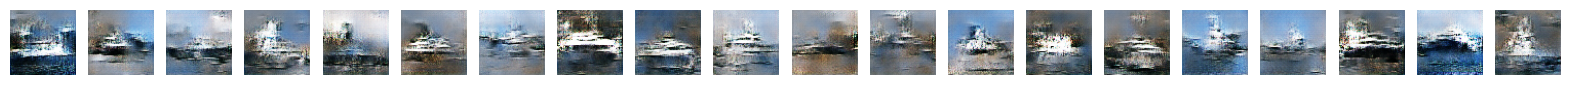

Modelo salvo após 100 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 310ms/step - d_loss: 0.3295 - g_loss: 2.5151
Epoch 101/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3474 - g_loss: 2.4444   - FID: 201.23672485351562 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 307ms/step - d_loss: 0.3474 - g_loss: 2.4441
Epoch 102/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3409 - g_loss: 2.4513   - FID: 207.8519744873047 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 306ms/step - d_loss: 0.3408 - g_loss: 2.4521
Epoch 103/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3332 - g_loss: 2.5193   - FID: 204.96543884277344 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 305ms/step - d_loss: 0.3332 - g_loss: 2.5191
Epoch 104/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3306 - g_loss: 2.4034   - FID: 197.7689971923828 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 306ms/step - d_loss: 0.3307 - g_loss: 2.4033
Epoch 105/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3413 - g_loss: 2.3422   - FID

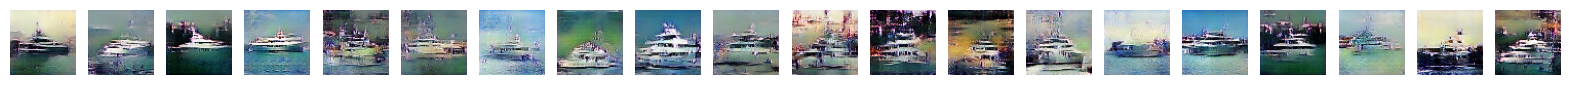

Modelo salvo após 200 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 310ms/step - d_loss: 0.3371 - g_loss: 2.4423
Epoch 201/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2967 - g_loss: 2.9141   - FID: 153.64659118652344 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 307ms/step - d_loss: 0.2968 - g_loss: 2.9137
Epoch 202/2000
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3080 - g_loss: 2.5333   - FID: 150.38832092285156 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 306ms/step - d_loss: 0.3081 - g_loss: 2.5330
Epoch 203/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3496 - g_loss: 2.3836   - FID: 160.84507751464844 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 307ms/step - d_loss: 0.3495 - g_loss: 2.3839
Epoch 204/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3253 - g_loss: 2.5587   - FID: 147.12594604492188 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 309ms/step - d_loss: 0.3253 - g_loss: 2.5584
Epoch 205/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3147 - g_loss: 2.7909   - F

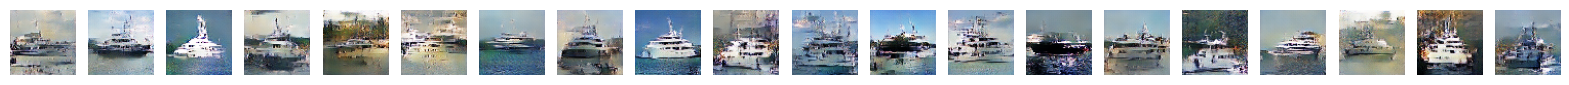

Modelo salvo após 300 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 308ms/step - d_loss: 0.2792 - g_loss: 2.7568
Epoch 301/2000
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3122 - g_loss: 2.6707   - FID: 124.24349212646484 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 308ms/step - d_loss: 0.3123 - g_loss: 2.6702
Epoch 302/2000
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3282 - g_loss: 2.5194   - FID: 110.33840942382812 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 308ms/step - d_loss: 0.3283 - g_loss: 2.5192
Epoch 303/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3233 - g_loss: 2.4875   - FID: 112.80229187011719 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 306ms/step - d_loss: 0.3233 - g_loss: 2.4873
Epoch 304/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3025 - g_loss: 2.7103   - FID: 119.61436462402344 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 308ms/step - d_loss: 0.3025 - g_loss: 2.7100
Epoch 305/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3179 - g_loss: 2.7247   - F

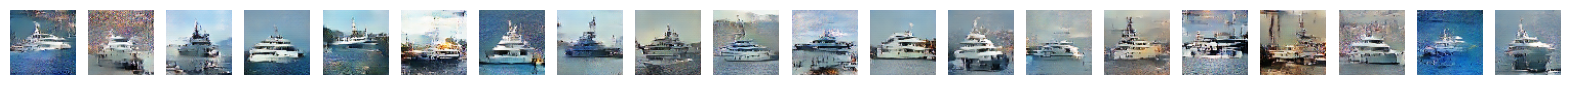

Modelo salvo após 400 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 314ms/step - d_loss: 0.3009 - g_loss: 2.8229
Epoch 401/2000
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2545 - g_loss: 3.0116   - FID: 104.75560760498047 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 310ms/step - d_loss: 0.2545 - g_loss: 3.0113
Epoch 402/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2688 - g_loss: 2.9271   - FID: 105.19876098632812 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 308ms/step - d_loss: 0.2688 - g_loss: 2.9273
Epoch 403/2000
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2801 - g_loss: 2.8459   - FID: 106.45680236816406 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 308ms/step - d_loss: 0.2801 - g_loss: 2.8456
Epoch 404/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2722 - g_loss: 2.8454   - FID: 118.7755126953125 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 308ms/step - d_loss: 0.2722 - g_loss: 2.8458
Epoch 405/2000
167/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2618 - g_loss: 2.8796   - FI

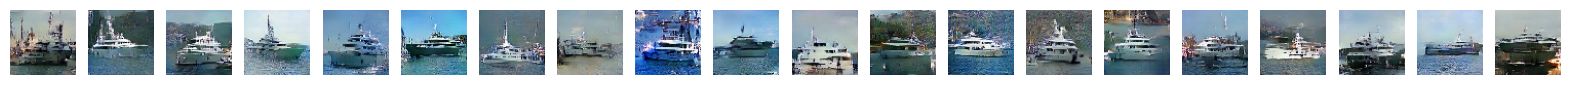

Modelo salvo após 500 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 312ms/step - d_loss: 0.2096 - g_loss: 3.6811
Epoch 501/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2082 - g_loss: 3.4739   - FID: 111.17304229736328 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 309ms/step - d_loss: 0.2082 - g_loss: 3.4739
Epoch 502/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2275 - g_loss: 3.3939   - FID: 97.22247314453125 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 308ms/step - d_loss: 0.2275 - g_loss: 3.3940
Epoch 503/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2110 - g_loss: 3.5454   - FID: 100.16268920898438 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 309ms/step - d_loss: 0.2110 - g_loss: 3.5452
Epoch 504/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2160 - g_loss: 3.3838   - FID: 109.58414459228516 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 308ms/step - d_loss: 0.2160 - g_loss: 3.3839
Epoch 505/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2292 - g_loss: 3.4539   - FI

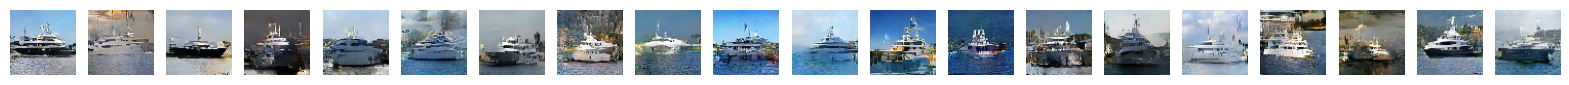

Modelo salvo após 600 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 318ms/step - d_loss: 0.1551 - g_loss: 4.2364
Epoch 601/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1776 - g_loss: 4.2671   - FID: 96.98583221435547 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 311ms/step - d_loss: 0.1775 - g_loss: 4.2667
Epoch 602/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1614 - g_loss: 4.1995   - FID: 97.58739471435547 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 307ms/step - d_loss: 0.1614 - g_loss: 4.1992
Epoch 603/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1620 - g_loss: 4.0816   - FID: 95.4834213256836 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 306ms/step - d_loss: 0.1620 - g_loss: 4.0818
Epoch 604/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1714 - g_loss: 4.2043   - FID: 103.26573944091797 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 307ms/step - d_loss: 0.1713 - g_loss: 4.2048
Epoch 605/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1642 - g_loss: 4.2486   - FID: 

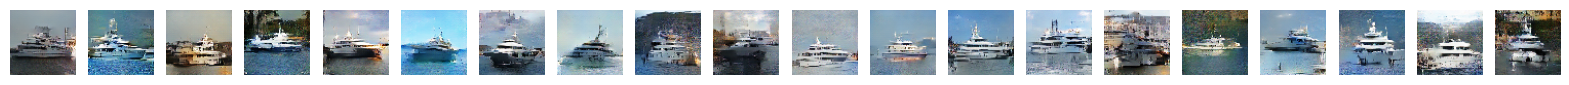

Modelo salvo após 700 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 311ms/step - d_loss: 0.1093 - g_loss: 5.1571
Epoch 701/2000
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1217 - g_loss: 5.1101   - FID: 92.15675354003906 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 317ms/step - d_loss: 0.1217 - g_loss: 5.1112
Epoch 702/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1198 - g_loss: 5.3633   - FID: 102.11721801757812 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 314ms/step - d_loss: 0.1198 - g_loss: 5.3630
Epoch 703/2000
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1341 - g_loss: 5.2019   - FID: 106.76983642578125 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 313ms/step - d_loss: 0.1340 - g_loss: 5.2022
Epoch 704/2000
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1116 - g_loss: 5.4299   - FID: 94.31755065917969 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 310ms/step - d_loss: 0.1116 - g_loss: 5.4283
Epoch 705/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1283 - g_loss: 5.2834   - FID

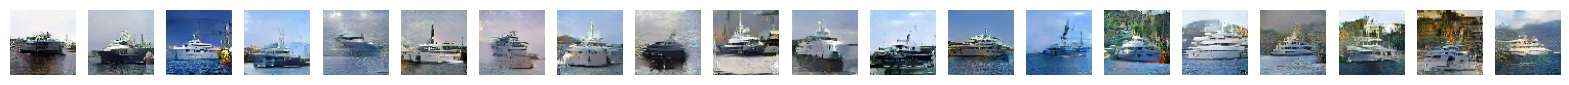

Modelo salvo após 800 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 311ms/step - d_loss: 0.0816 - g_loss: 6.3848
Epoch 801/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0947 - g_loss: 6.5557   - FID: 93.1734390258789 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 306ms/step - d_loss: 0.0947 - g_loss: 6.5552
Epoch 802/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.0748 - g_loss: 6.6616   - FID: 91.51802825927734 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 320ms/step - d_loss: 0.0748 - g_loss: 6.6615
Epoch 803/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0766 - g_loss: 6.6773   - FID: 94.89414978027344 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 314ms/step - d_loss: 0.0766 - g_loss: 6.6762
Epoch 804/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0712 - g_loss: 6.7581   - FID: 95.51360321044922 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 315ms/step - d_loss: 0.0712 - g_loss: 6.7579
Epoch 805/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0793 - g_loss: 6.8357   - FID: 9

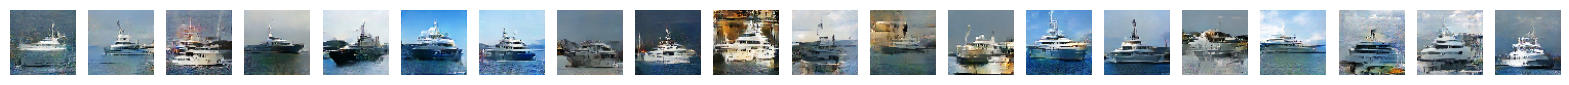

Modelo salvo após 900 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 311ms/step - d_loss: 0.0538 - g_loss: 8.4575
Epoch 901/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0606 - g_loss: 8.2278   - FID: 93.76083374023438 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 310ms/step - d_loss: 0.0606 - g_loss: 8.2274
Epoch 902/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0625 - g_loss: 8.2627   - FID: 92.2392349243164 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 323ms/step - d_loss: 0.0625 - g_loss: 8.2631
Epoch 903/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0519 - g_loss: 8.4066   - FID: 97.35333251953125 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 313ms/step - d_loss: 0.0520 - g_loss: 8.4055
Epoch 904/2000
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0524 - g_loss: 8.1720   - FID: 95.35289001464844 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 319ms/step - d_loss: 0.0523 - g_loss: 8.1726
Epoch 905/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0647 - g_loss: 7.9638   - FID: 9

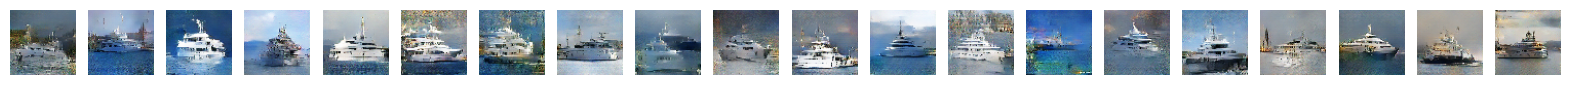

Modelo salvo após 1000 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 312ms/step - d_loss: 0.0494 - g_loss: 9.9813
Epoch 1001/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0338 - g_loss: 10.1433   - FID: 90.98089599609375 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 321ms/step - d_loss: 0.0338 - g_loss: 10.1441
Epoch 1002/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0161 - g_loss: 10.3473   - FID: 90.79000091552734 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 318ms/step - d_loss: 0.0161 - g_loss: 10.3467
Epoch 1003/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0242 - g_loss: 10.5873   - FID: 98.40628051757812 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 320ms/step - d_loss: 0.0242 - g_loss: 10.5859
Epoch 1004/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0217 - g_loss: 10.1913   - FID: 87.73744201660156 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 317ms/step - d_loss: 0.0217 - g_loss: 10.1915
Epoch 1005/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0249 - g_loss: 10

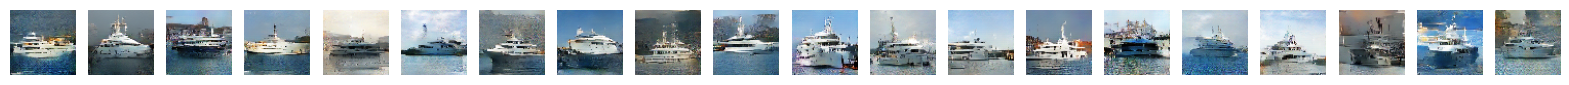

Modelo salvo após 1100 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 313ms/step - d_loss: 0.0173 - g_loss: 12.1000
Epoch 1101/2000
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0027 - g_loss: 12.7798   - FID: 81.18803405761719 .
Melhor FID encontardo: 81.18803405761719, salvando gerador...
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 310ms/step - d_loss: -0.0026 - g_loss: 12.7779
Epoch 1102/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0012 - g_loss: 12.7164   - FID: 92.56377410888672 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 311ms/step - d_loss: -0.0011 - g_loss: 12.7150
Epoch 1103/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0119 - g_loss: 12.4954   - FID: 93.55046844482422 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 310ms/step - d_loss: 0.0119 - g_loss: 12.4959
Epoch 1104/2000
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0070 - g_loss: 12.9624   - FID: 95.33255767822266 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 310ms/step - d_loss: 0.0070 - g_loss: 12.9604
Epoch 1105/2000
169/

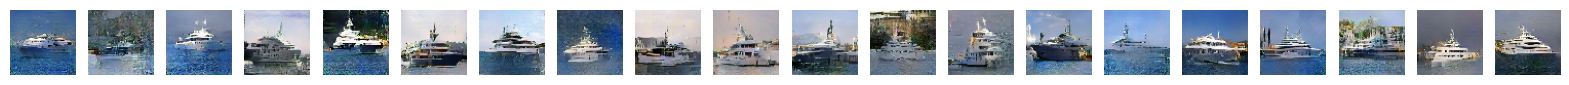

Modelo salvo após 1200 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 313ms/step - d_loss: 0.0030 - g_loss: 15.2788
Epoch 1201/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0056 - g_loss: 15.1640   - FID: 85.8754653930664 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 310ms/step - d_loss: -0.0057 - g_loss: 15.1631
Epoch 1202/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0067 - g_loss: 14.7958   - FID: 91.69860076904297 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 326ms/step - d_loss: -0.0067 - g_loss: 14.7952
Epoch 1203/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0201 - g_loss: 14.9138   - FID: 91.16007232666016 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 321ms/step - d_loss: -0.0201 - g_loss: 14.9140
Epoch 1204/2000
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0020 - g_loss: 14.9088   - FID: 88.91851806640625 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 318ms/step - d_loss: 0.0019 - g_loss: 14.9089
Epoch 1205/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0172 - g_l

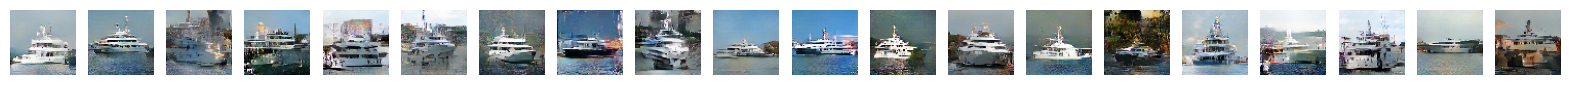

Modelo salvo após 1300 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 313ms/step - d_loss: -0.0247 - g_loss: 18.4626
Epoch 1301/2000
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0171 - g_loss: 17.9689   - FID: 87.63883972167969 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 324ms/step - d_loss: -0.0173 - g_loss: 17.9690
Epoch 1302/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0272 - g_loss: 17.9107   - FID: 94.4117202758789 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 323ms/step - d_loss: -0.0273 - g_loss: 17.9102
Epoch 1303/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0507 - g_loss: 18.0395   - FID: 99.22359466552734 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 316ms/step - d_loss: -0.0507 - g_loss: 18.0400
Epoch 1304/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0485 - g_loss: 18.6613   - FID: 93.82577514648438 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 316ms/step - d_loss: -0.0486 - g_loss: 18.6641
Epoch 1305/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0321 - 

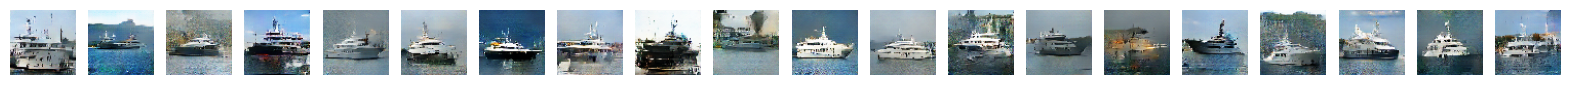

Modelo salvo após 1400 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 314ms/step - d_loss: -0.0239 - g_loss: 21.3479
Epoch 1401/2000
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0466 - g_loss: 21.1926   - FID: 91.21565246582031 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 313ms/step - d_loss: -0.0469 - g_loss: 21.1934
Epoch 1402/2000
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0471 - g_loss: 21.0344   - FID: 92.24161529541016 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 314ms/step - d_loss: -0.0471 - g_loss: 21.0339
Epoch 1403/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0291 - g_loss: 20.8293   - FID: 92.73947143554688 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 312ms/step - d_loss: -0.0292 - g_loss: 20.8300
Epoch 1404/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0619 - g_loss: 21.5736   - FID: 93.7889404296875 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 314ms/step - d_loss: -0.0619 - g_loss: 21.5705
Epoch 1405/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0622 - 

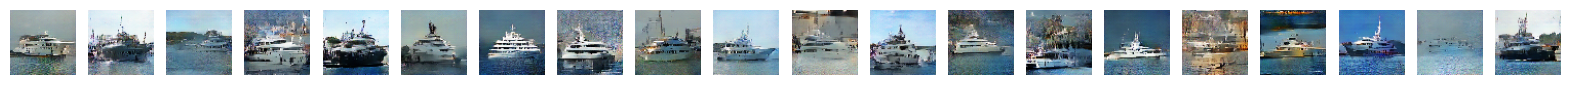

Modelo salvo após 1500 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 315ms/step - d_loss: -0.0806 - g_loss: 25.7220
Epoch 1501/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0594 - g_loss: 24.8253   - FID: 88.67675018310547 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 312ms/step - d_loss: -0.0594 - g_loss: 24.8263
Epoch 1502/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0820 - g_loss: 25.1150   - FID: 95.2754898071289 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 312ms/step - d_loss: -0.0820 - g_loss: 25.1132
Epoch 1503/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0738 - g_loss: 24.9095   - FID: 87.72901153564453 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 314ms/step - d_loss: -0.0738 - g_loss: 24.9116
Epoch 1504/2000
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.1005 - g_loss: 26.1745   - FID: 94.38983917236328 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 312ms/step - d_loss: -0.1004 - g_loss: 26.1723
Epoch 1505/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.1100 - 

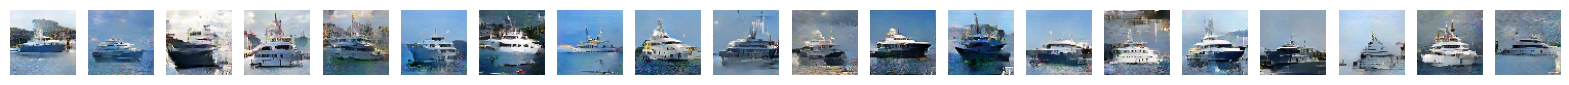

Modelo salvo após 1600 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 310ms/step - d_loss: -0.1027 - g_loss: 29.5955
Epoch 1601/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.1166 - g_loss: 30.0575   - FID: 91.40249633789062 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 316ms/step - d_loss: -0.1166 - g_loss: 30.0549
Epoch 1602/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.1201 - g_loss: 29.9675   - FID: 94.72696685791016 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 312ms/step - d_loss: -0.1200 - g_loss: 29.9650
Epoch 1603/2000
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0751 - g_loss: 30.7075   - FID: 89.56398010253906 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 315ms/step - d_loss: -0.0757 - g_loss: 30.7266
Epoch 1604/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0904 - g_loss: 30.5932   - FID: 97.05271911621094 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 317ms/step - d_loss: -0.0904 - g_loss: 30.5887
Epoch 1605/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.1140 -

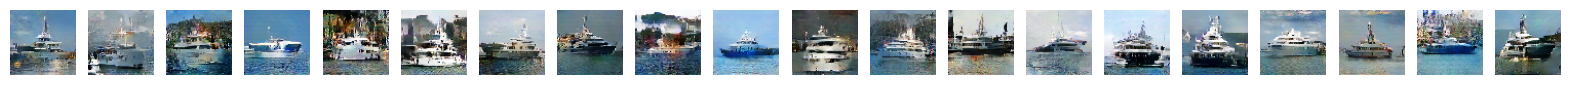

Modelo salvo após 1700 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 323ms/step - d_loss: -0.1092 - g_loss: 34.5069
Epoch 1701/2000
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.1041 - g_loss: 35.4065   - FID: 91.25029754638672 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 311ms/step - d_loss: -0.1044 - g_loss: 35.4067
Epoch 1702/2000
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.1492 - g_loss: 35.3349   - FID: 87.42182922363281 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 317ms/step - d_loss: -0.1492 - g_loss: 35.3349
Epoch 1703/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.1028 - g_loss: 35.0910   - FID: 91.31243896484375 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 310ms/step - d_loss: -0.1028 - g_loss: 35.0883
Epoch 1704/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.1854 - g_loss: 36.1679   - FID: 101.05303955078125 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 318ms/step - d_loss: -0.1853 - g_loss: 36.1663
Epoch 1705/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.1742 

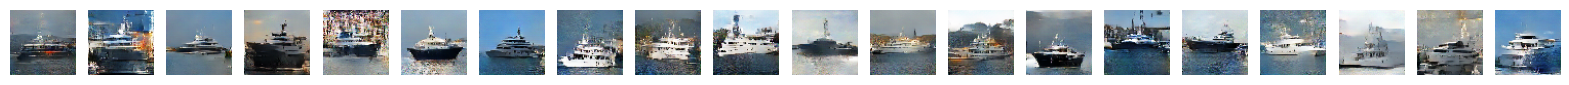

Modelo salvo após 1800 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 314ms/step - d_loss: -0.2139 - g_loss: 41.6449
Epoch 1801/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.1782 - g_loss: 41.3838   - FID: 92.815185546875 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 313ms/step - d_loss: -0.1782 - g_loss: 41.3855
Epoch 1802/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.2158 - g_loss: 41.8581   - FID: 93.48965454101562 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 310ms/step - d_loss: -0.2157 - g_loss: 41.8563
Epoch 1803/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.1673 - g_loss: 41.7356   - FID: 92.25335693359375 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 309ms/step - d_loss: -0.1674 - g_loss: 41.7394
Epoch 1804/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.1896 - g_loss: 41.1609   - FID: 88.25259399414062 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 317ms/step - d_loss: -0.1897 - g_loss: 41.1647
Epoch 1805/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.1037 - g

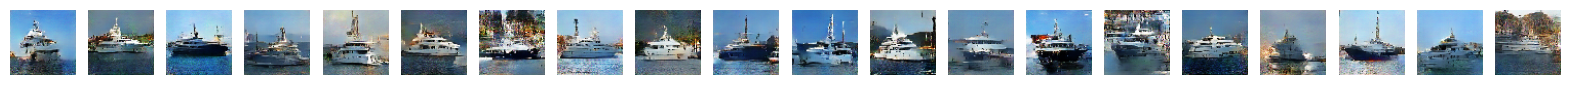

Modelo salvo após 1900 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 68s 403ms/step - d_loss: -0.2426 - g_loss: 51.3163
Epoch 1901/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.2694 - g_loss: 50.1296   - FID: 93.10319519042969 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 62s 365ms/step - d_loss: -0.2692 - g_loss: 50.1253
Epoch 1902/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.2423 - g_loss: 49.4180   - FID: 90.4204330444336 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 313ms/step - d_loss: -0.2423 - g_loss: 49.4162
Epoch 1903/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.2761 - g_loss: 49.9874   - FID: 88.39302825927734 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 316ms/step - d_loss: -0.2760 - g_loss: 49.9890
Epoch 1904/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.2576 - g_loss: 52.5030   - FID: 105.5006103515625 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 312ms/step - d_loss: -0.2576 - g_loss: 52.5129
Epoch 1905/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.2147 - 

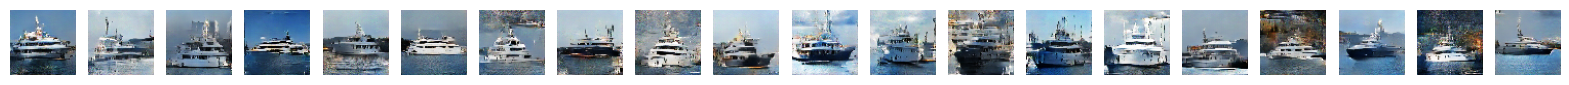

Modelo salvo após 2000 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 315ms/step - d_loss: -0.2828 - g_loss: 57.0986


In [10]:
### EXECUÇÃO ###



epochs = 2000
d_steps = 3
latent_dim = 128

save_fid = np.zeros(epochs)

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim, d_steps=d_steps)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

history = gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=540, latent_dim=latent_dim)]
)

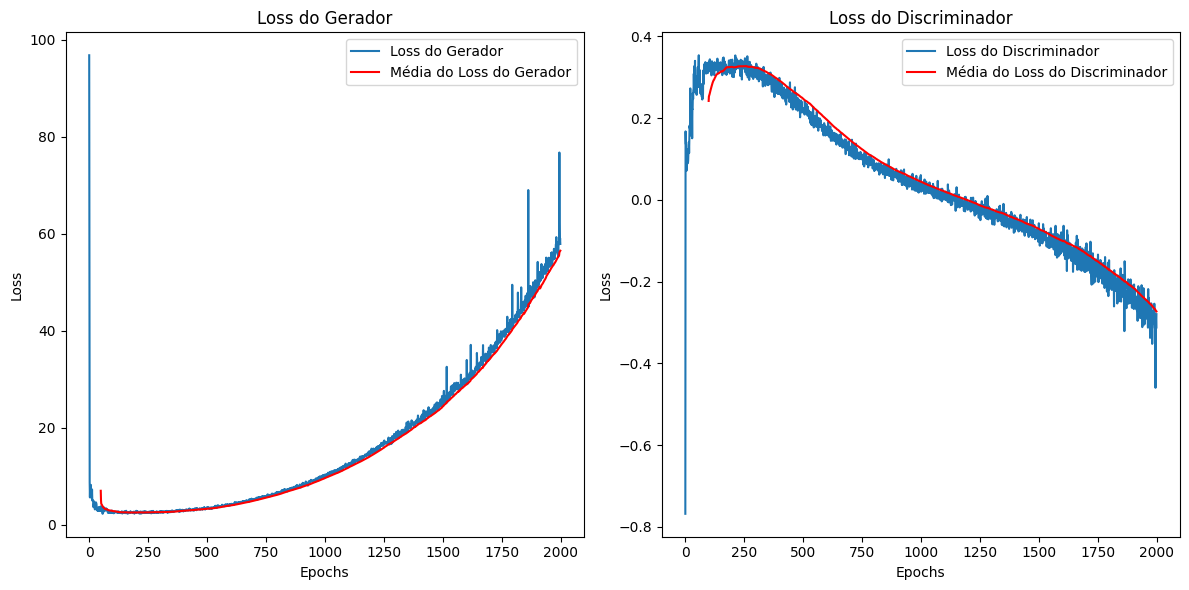

In [11]:
generator_loss = history.history['g_loss']
generator_loss_series = pd.Series(generator_loss)
generator_loss_rolling = generator_loss_series.rolling(window=50).mean()

discriminator_loss = history.history['d_loss']
discriminator_loss_series = pd.Series(discriminator_loss)
discriminator_loss_rolling = discriminator_loss_series.rolling(window=100).mean()

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(generator_loss, label='Loss do Gerador')
plt.plot(generator_loss_rolling, color='r', linestyle='-', label = 'Média do Loss do Gerador')
plt.title('Loss do Gerador')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(discriminator_loss, label='Loss do Discriminador')
plt.plot(discriminator_loss_rolling, color='r', linestyle='-', label = 'Média do Loss do Discriminador')
plt.title('Loss do Discriminador')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Menor FID:           81.18803405761719
Época da menor perda:  1100


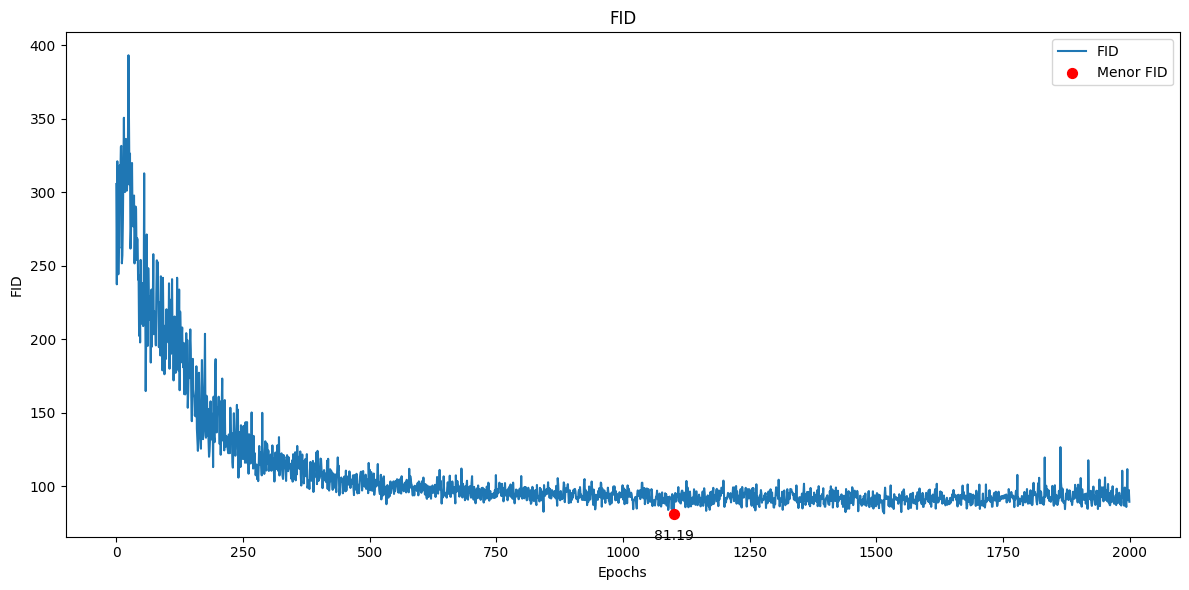

In [12]:
menor_fid = 999
for i in range(epochs):
    if save_fid[i]<menor_fid:
        menor_fid = save_fid[i]
        epoch_m = i
        
print('Menor FID:          ',menor_fid)
print('Época da menor perda: ',epoch_m)

plt.figure(figsize=(12,6))
plt.plot(save_fid, label='FID')
plt.scatter(epoch_m, menor_fid, color='r', zorder=5, label = 'Menor FID', s=50)
plt.text(epoch_m, menor_fid-20, f"{menor_fid:.2f}", ha='center', va='bottom')
plt.title('FID')
plt.xlabel('Epochs')
plt.ylabel('FID')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
generator = keras.models.load_model(best_path)
discriminator = keras.models.load_model(best_path.replace("best_dcgan_checkpoint", "best_dcgan_discriminator"))

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim, d_steps=d_steps)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

In [14]:
num_img = 5400
output_dir = str(fake_dir + "/" + generating_class + "/")
os.makedirs(output_dir, exist_ok=True)
filename = str(generating_class + "%d.png")
output_path = os.path.join(output_dir, filename)

latent_dim=128
seed_generator = keras.random.SeedGenerator(1337)

for i in tqdm(range(num_img),desc="Gerando imagens"):
    random_latent_vectors = keras.random.normal(
        shape=(1, latent_dim), seed=seed_generator
    )
    generated_images = gan.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()
    img = keras.utils.array_to_img(generated_images[0])
    img.save(output_path % (i))

Gerando imagens: 100%|██████████████████████████████████████████████████████████████| 5400/5400 [00:56<00:00, 95.79it/s]


/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
Processando classe 'YACHT': 100%|█████████████████████████████████████████████████████| 540/540 [08:27<00:00,  1.06it/s]



Métricas para a classe 'YACHT':
  SSIM (média): 0.2978
  Inception Score (Real): 1.5913
  Inception Score (Gerado): 1.9701
  FID: 70.8692


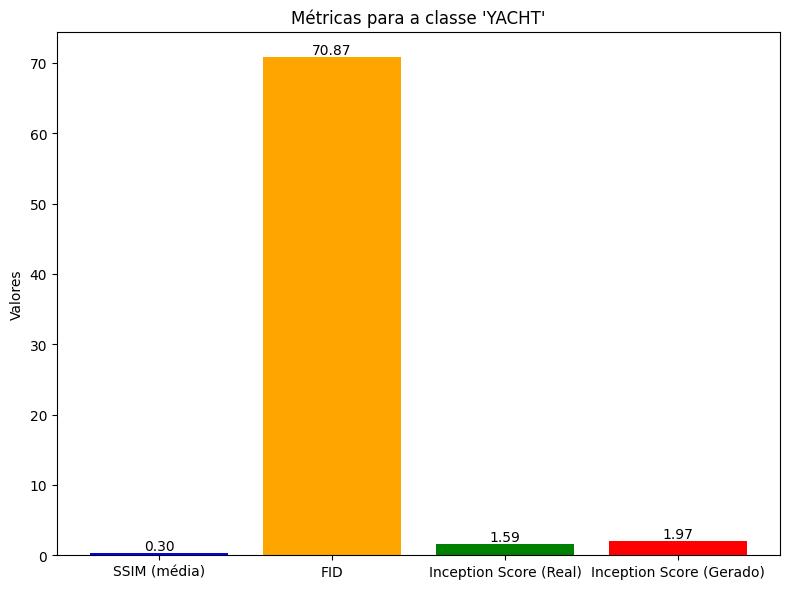

In [15]:
metrics = calculate_metrics(real_dir, fake_dir, generating_class, num_samples=num_img)
print_metrics(metrics, generating_class)
plot_metrics_for_class(metrics, generating_class)

Processando classe 'YACHT': 100%|█████████████████████████████████████████████████████| 540/540 [09:34<00:00,  1.06s/it]



Métricas para a classe 'YACHT':
  SSIM (média): 0.1694
  Inception Score (Real): 1.8708
  Inception Score (Gerado): 1.9419
  FID: 45.8311


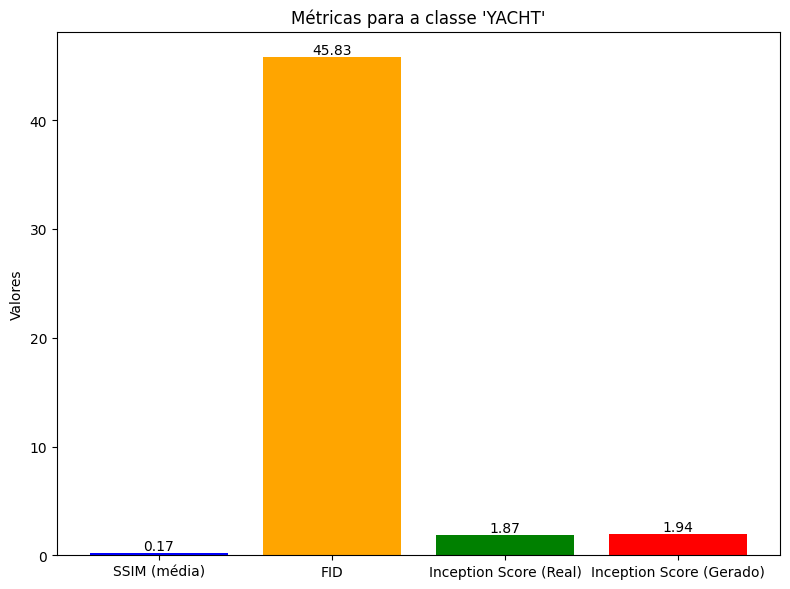

In [19]:
metrics = calculate_metrics(real_dir, fake_dir, generating_class, num_samples=num_img)
print_metrics(metrics, generating_class)
plot_metrics_for_class(metrics, generating_class)

In [16]:
# Caminhos para as imagens de entrada e saída
input_dir = str(fake_dir + '/' + generating_class)   # Substitua pelo diretório das imagens de entrada
output_dir = str(fake_dirx4 + '/' + generating_class)  # Substitua pelo diretório das imagens de saída

# Certifique-se de que o diretório de saída existe
os.makedirs(output_dir, exist_ok=True)

process_images(input_dir, output_dir)
print("Processamento concluído!")

Aumentando imagens: 100%|███████████████████████████████████████████████████████████| 5400/5400 [04:52<00:00, 18.44it/s]

Processamento concluído!


Processando classe 'YACHT': 100%|█████████████████████████████████████████████████████| 540/540 [13:02<00:00,  1.45s/it]



Métricas para a classe 'YACHT':
  SSIM (média): 0.2078
  Inception Score (Real): 1.8703
  Inception Score (Gerado): 2.0388
  FID: 23.2861


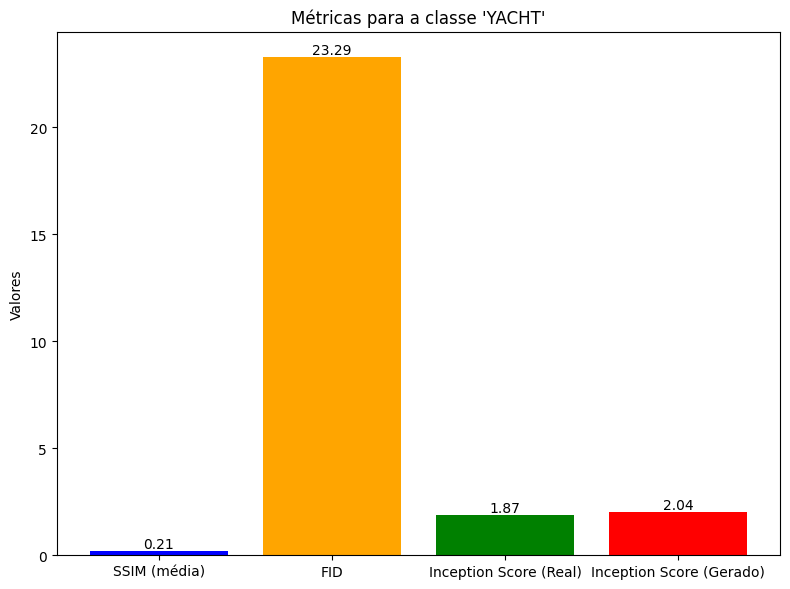

In [20]:
metrics = calculate_metrics(real_dir, fake_dirx4, generating_class, num_samples=num_img)
print_metrics(metrics, generating_class)
plot_metrics_for_class(metrics, generating_class)